# Creating your own EmissionModel

To create your own `EmissionModel` all you need to do is define each indiviudal emission type and relate them. This operation will define a tree-like structure, where each model links to at least one other model. 

In the sections below we will detail how to define each different type of emission operation, but there are a few arguments needed by an ``EmissionModel`` regardless of the operation:

- A ***label*** which identifies the model. This is given by passing a string to the ``label`` argument. These must be unique within a single emission model "tree".
- An ***emitter*** to act on. This is given by passing a string to the ``emitter`` argument. Currently the possible emitters are: ``"stellar"``, ``"blackhole"``, and ``"galaxy"``. 

Before demonstrating anythign we first need to import the classes we'll need and set up a ``Grid`` (described [here](../grids/grids.rst)).

In [1]:
from unyt import cm, dimensionless, kelvin, km, s

from synthesizer.emission_models import EmissionModel
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Blackbody
from synthesizer.grid import Grid

# Get the grid which we'll need for extraction
grid_dir = "../../../tests/test_grid"
grid_name = "test_grid"
grid = Grid(grid_name, grid_dir=grid_dir)


## Emitters

The emitter on a model defines: 

- Where any model independant attributes should be extracted from (e.g. ages and metallicites needed for stellar extractions).
- Where the resulting spectra/lines will be stored once generated. 
- Where any model attributes set to attribute strings should be extracted from (e.g. optical depths when ``tau_v="tau_v"``).

`"stellar"` will cause the model to use a `Stars` object, `"blackhole"` will cause the model to use a `BlackHole/s` object, while `"galaxy"` will cause the model to use a `Galaxy` object. This mechanism is all performed behind the scenes, you should never have to interact directly with any of this beyond setting the emitter string on a model.

As well as the base `EmissionModel` classes there are 3 specialised model classes: `StellarEmissionModel`, `BlackHoleEmissionModel`, and `GalaxyEmissionModel`. These specialised classes are identical to the base `EmissionModel` class but automatically set the ``emitter`` argument to ``"stellar"``, ``"blackhole"``, and ``"galaxy"`` respectively.

We'll cover the specifics of different operations below, but this means the following fake models:

In [2]:
transmitted = EmissionModel(
    "transmitted",
    grid=grid,
    extract="transmitted",
    fesc=0.3,
    emitter="stellar",
)
nlr = EmissionModel(
    "nlr",
    grid=grid,
    extract="nebular",
    fesc=0.3,
    emitter="blackhole",
)
total = EmissionModel(
    "total",
    combine=(transmitted, nlr),
    emitter="galaxy",
)

are equivalent to:

In [3]:
from synthesizer.emission_models import (
    BlackHoleEmissionModel,
    GalaxyEmissionModel,
    StellarEmissionModel,
)

transmitted = StellarEmissionModel(
    "transmitted",
    grid=grid,
    extract="transmitted",
    fesc=0.3,
)
nlr = BlackHoleEmissionModel(
    "nlr",
    grid=grid,
    extract="nebular",
    fesc=0.3,
)
total = GalaxyEmissionModel(
    "total",
    combine=(transmitted, nlr),
)


In the rest of this notebook we'll use these specialised classes rather than the base `EmissionModel`.


## Defining an extraction

To define an extraction we simply need to pass a `Grid` to extract from and a key to extract (with the option of providing an escape fraction).

In [4]:
transmitted = StellarEmissionModel(
    "transmitted",
    grid=grid,
    extract="transmitted",
    fesc=0.3,
)
print(transmitted)

|==== EmissionModel: transmitted ====|
|------------------------------------|
|  TRANSMITTED (stellar)             |
|------------------------------------|
|Extraction model:                   |
|  Grid: test_grid                   |
|  Extract key: transmitted          |
|  Escape fraction: 0.3              |
|  Save emission: True               |
|====================================|


## Defining a combination

To define a combination we simply pass the models we want combined to the `combine` keyword (along with a label).

In [5]:
# Define models to combine
linecont = StellarEmissionModel(
    "linecont",
    grid=grid,
    extract="linecont",
    mask_attr="log10ages",
    mask_thresh=7 * dimensionless,
    mask_op="<",
    fesc=0.7,
)
nebular_cont = StellarEmissionModel(
    "nebular_continuum",
    grid=grid,
    extract="nebular_continuum",
    mask_attr="log10ages",
    mask_thresh=7 * dimensionless,
    mask_op="<",
)

# Define the combined model
nebular = StellarEmissionModel("nebular", combine=(linecont, nebular_cont))
print(nebular)

|================ EmissionModel: nebular ===============|
|-------------------------------------------------------|
|  LINECONT (stellar)                                   |
|-------------------------------------------------------|
|Extraction model:                                      |
|  Grid: test_grid                                      |
|  Extract key: linecont                                |
|  Escape fraction: 0.7                                 |
|  Save emission: True                                  |
|  Masks:                                               |
|    - log10ages < 7 dimensionless                      |
|-------------------------------------------------------|
|  NEBULAR_CONTINUUM (stellar)                          |
|-------------------------------------------------------|
|Extraction model:                                      |
|  Grid: test_grid                                      |
|  Extract key: nebular_continuum                       |
|  Escape frac

## Defining an attenuation

To define an attenuated emission model we need a dust curve, the model to apply the dust to, and an optical depth (once again along with a label).

Some properties can also have strings passed instead of numbers. When a string is passed the spectra generator method will look for an attribute on an emitter using this string. This is only applicable for certain properties, e.g. `tau_v` and `fesc`.

In [6]:
attenuated = StellarEmissionModel(
    "attenuated",
    dust_curve=PowerLaw(slope=-1),
    apply_dust_to=nebular,
    tau_v="tau_v",
)
print(attenuated)

|====================================== EmissionModel: attenuated =======================================|
|--------------------------------------------------------------------------------------------------------|
|  LINECONT (stellar)                                                                                    |
|--------------------------------------------------------------------------------------------------------|
|Extraction model:                                                                                       |
|  Grid: test_grid                                                                                       |
|  Extract key: linecont                                                                                 |
|  Escape fraction: 0.7                                                                                  |
|  Save emission: True                                                                                   |
|  Masks:                            

The optical depth specifically (`tau_v`) can also take a tuple containing either strings or floats which will be combined into a single attenuation curve when used.

In [7]:
attenuated = StellarEmissionModel(
    "attenuated",
    dust_curve=PowerLaw(slope=-1),
    apply_dust_to=nebular,
    tau_v=("tau_v", 0.33),
)
print(attenuated)

|====================================== EmissionModel: attenuated =======================================|
|--------------------------------------------------------------------------------------------------------|
|  LINECONT (stellar)                                                                                    |
|--------------------------------------------------------------------------------------------------------|
|Extraction model:                                                                                       |
|  Grid: test_grid                                                                                       |
|  Extract key: linecont                                                                                 |
|  Escape fraction: 0.7                                                                                  |
|  Save emission: True                                                                                   |
|  Masks:                            

## Defining a generation

To define a generation model we only need to provide the generator class (i.e. a ``Blackbody``).

In [8]:
from synthesizer.emission_models.dust.emission import Blackbody

bb_emission = StellarEmissionModel(
    "blackbody_emission",
    generator=Blackbody(50 * kelvin),
)
print(bb_emission)

|========================================= EmissionModel: blackbody_emission =========================================|
|---------------------------------------------------------------------------------------------------------------------|
|  BLACKBODY_EMISSION (stellar)                                                                                       |
|---------------------------------------------------------------------------------------------------------------------|
|Generation model:                                                                                                    |
|  Emission generation model: <synthesizer.emission_models.dust.emission.Blackbody object at 0x7fe6a80dd300>          |
|  Save emission: True                                                                                                |
|=====================================================================================================================|


If we want to scale the generated emission by another emission model we can pass that as the ``lum_intrinsic_model``.

In [9]:
scaled_bb_emission = StellarEmissionModel(
    "blackbody_emission",
    generator=Blackbody(50 * kelvin),
    lum_intrinsic_model=transmitted,
)
print(scaled_bb_emission)

|========================================= EmissionModel: blackbody_emission =========================================|
|---------------------------------------------------------------------------------------------------------------------|
|  TRANSMITTED (stellar)                                                                                              |
|---------------------------------------------------------------------------------------------------------------------|
|Extraction model:                                                                                                    |
|  Grid: test_grid                                                                                                    |
|  Extract key: transmitted                                                                                           |
|  Escape fraction: 0.3                                                                                               |
|  Save emission: True                  

For the special case of energy balance dust emission you can pass both the intrinsic and attenuated models to scale by the emission reprocessed by dust.

In [10]:
dust_emission = GalaxyEmissionModel(
    "blackbody_emission",
    generator=Blackbody(50 * kelvin),
    lum_intrinsic_model=transmitted,
    lum_attenuated_model=attenuated,
)
print(dust_emission)

|========================================= EmissionModel: blackbody_emission =========================================|
|---------------------------------------------------------------------------------------------------------------------|
|  LINECONT (stellar)                                                                                                 |
|---------------------------------------------------------------------------------------------------------------------|
|Extraction model:                                                                                                    |
|  Grid: test_grid                                                                                                    |
|  Extract key: linecont                                                                                              |
|  Escape fraction: 0.7                                                                                               |
|  Save emission: True                  

## Including a mask

A mask can be included in any step by passing `mask_attr`, `mask_thresh`, and `mask_op`.

In [11]:
masked_transmitted = StellarEmissionModel(
    "masked_transmitted",
    grid=grid,
    extract="transmitted",
    fesc="fesc",
    mask_attr="log10ages",
    mask_thresh=7 * dimensionless,
    mask_op="<",
)

We can also define multiple masks on a single step.
To add more masks, use the ``add_mask`` method, as demonstrated on the [premade models](premade_models/premade_models.rst).
These will be combined with a boolean ``and`` operation at the point of spectra generation.

In [12]:
masked_transmitted.add_mask("metallicities", "<", 0.01 * dimensionless)
masked_transmitted.add_mask("log10ages", "<", 6 * dimensionless)
print(masked_transmitted)

|======== EmissionModel: masked_transmitted ========|
|---------------------------------------------------|
|  MASKED_TRANSMITTED (stellar)                     |
|---------------------------------------------------|
|Extraction model:                                  |
|  Grid: test_grid                                  |
|  Extract key: transmitted                         |
|  Escape fraction: fesc                            |
|  Save emission: True                              |
|  Masks:                                           |
|    - log10ages < 7 dimensionless                  |
|    - metallicities < 0.01 dimensionless           |
|    - log10ages < 6 dimensionless                  |
|===================================================|


## Including related models

In many instances you'll have a primary emissions spectra that you wish to calculate, plus some extra emission models that get produced along the way, but do not feature in the main "tree".
To include these models, and ensure their spectra is generated by calls to ``get_spectra`` or ``get_lines`` methods, you can pass them to the ``related_models`` argument at instantiation.

In [13]:
# Define the combined model
nebular = StellarEmissionModel(
    "nebular", combine=(linecont, nebular_cont), related_models=(transmitted)
)
print(nebular)

|================ EmissionModel: nebular ===============|
|-------------------------------------------------------|
|  LINECONT (stellar)                                   |
|-------------------------------------------------------|
|Extraction model:                                      |
|  Grid: test_grid                                      |
|  Extract key: linecont                                |
|  Escape fraction: 0.7                                 |
|  Save emission: True                                  |
|  Masks:                                               |
|    - log10ages < 7 dimensionless                      |
|-------------------------------------------------------|
|  NEBULAR_CONTINUUM (stellar)                          |
|-------------------------------------------------------|
|Extraction model:                                      |
|  Grid: test_grid                                      |
|  Extract key: nebular_continuum                       |
|  Escape frac

## Fixing parameters

When an emission model is used in a ``get_spectra`` method, any parameters the model does not define will be extracted from the emitter.
If you would like to set any of these to fixed values you can pass a dictionary of parameters to a model at instantiation.

For demonstration purposes, below we create an AGN NLR emission model with fixed NLR parameters.
This can also be done with a setter after instantiation (see the model modification [docs](modify_models.ipynb)).

In [14]:
# Get the NLR and BLR grids
nlr_grid = Grid("test_grid_agn-nlr", grid_dir="../../../tests/test_grid")

nlr = BlackHoleEmissionModel(
    label="nlr",
    extract="nebular",
    grid=nlr_grid,
    fesc=0.1,  # covering fraction
    fixed_parameters={
        "ionisation_parameter_nlr": 0.01,
        "hydrogen_density_nlr": 1e4 / cm**3,
        "covering_fraction_nlr": 0.1,
        "velocity_dispersion_nlr": 500 * km / s,
    },
)
print(nlr)

|================= EmissionModel: nlr =================|
|------------------------------------------------------|
|  NLR (blackhole)                                     |
|------------------------------------------------------|
|Extraction model:                                     |
|  Grid: test_grid_agn-nlr                             |
|  Extract key: nebular                                |
|  Escape fraction: 0.1                                |
|  Save emission: True                                 |
|  Fixed parameters:                                   |
|    - ionisation_parameter_nlr: 0.01                  |
|    - hydrogen_density_nlr: 10000.0 cm**(-3)          |
|    - covering_fraction_nlr: 0.1                      |
|    - velocity_dispersion_nlr: 500 km/s               |
|======================================================|


## Using post processing functions

You may want to apply some post processing to your resulting spectra that isn't offered by synthesizer.
In these cases you can pass a list of "post processing functions" to the ``EmissionModel``.
These functions will be called in the order they are passed, after all spectra have been generated. 

These post processing functions must take the following arguments:

- A dictionary of spectra / lines, where the dictionary will be filled by key-value pairs of emission model labels and the spectra / lines they produce (``Sed``/``LineCollection``) ``{<model.label>: <spectra / lines>}``. 
- A dictionary of galaxy / component objects, where the dictionary will be ``{"stellar": Stars, "blackhole": BlackHoles, "galaxy": Galaxy}``.
- An ``EmissionModel``. 

Each post processing function should also return the dictionary of spectra / lines with the modified values.

When ``get_spectra`` is called, and all spectra have been generated, any post processing functions will be called with these arguments (in the order listed above).

Below we define a **fake** function to perform some arbitrary mass scaling of the spectra. 

In [15]:
def scale_by_mass(emission, emitters, model):
    """
    Scale the emission by mass.

    Args:
        emission (dict): A dictionary of emissions.
        emitters (dict): A dictionary of emitters.
        model (EmissionModel): The model defining the emissions.
    """
    # Loop over emissions
    for key, value in emission.values():
        # Get model
        this_model = model[key]

        # Get the emitter
        emitter = emitters[this_model.emitter]

        # Scale the emission
        value *= emitter.masses

    return emission


nebular = StellarEmissionModel(
    "nebular",
    combine=(linecont, nebular_cont),
    related_models=(transmitted),
    post_processing=(scale_by_mass,),
)

# Saving or not saving the emission

By default all emissions produced by a model will be attached to an emitter after generation. If you would like to instead discard a spectra (but still have it generated for making other spectra) you can pass `save=False` to the emission model at instantiation.

In [16]:
throw_away = StellarEmissionModel(
    "throw_away",
    combine=(linecont, nebular_cont),
    save=False,
)

## Putting it all together

In the example below we demonstrate how to construct a complex model piece by piece. 
This will construct the `TotalEmission` model with the [Charlot&Fall+2000](https://ui.adsabs.harvard.edu/abs/2000ApJ...539..718C/abstract) like attenuation operation explicitly.

Here we'll use the base `EmissionModel` class to explictly show the setting of the `emitter` argument. Notice how we associate the dust emission and total emission on the galaxy rather than the stellar component.

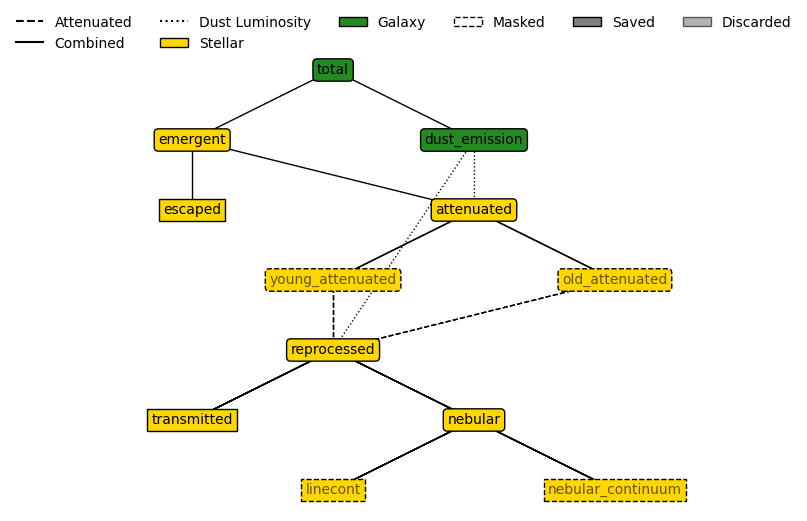

|================================================ EmissionModel: total ===============================================|
|---------------------------------------------------------------------------------------------------------------------|
|  TRANSMITTED (stellar)                                                                                              |
|---------------------------------------------------------------------------------------------------------------------|
|Extraction model:                                                                                                    |
|  Grid: test_grid                                                                                                    |
|  Extract key: transmitted                                                                                           |
|  Escape fraction: 0.3                                                                                               |
|  Save emission: True                  

In [17]:
# Define the extractions
transmitted = EmissionModel(
    "transmitted",
    grid=grid,
    extract="transmitted",
    fesc=0.3,
    emitter="stellar",
)
escaped = EmissionModel(
    "escaped", grid=grid, extract="transmitted", fesc=0.7, emitter="stellar"
)
linecont = EmissionModel(
    "linecont",
    grid=grid,
    extract="linecont",
    mask_attr="log10ages",
    mask_thresh=7 * dimensionless,
    mask_op="<",
    fesc=0.7,
    emitter="stellar",
    save=False,
)
nebular_cont = EmissionModel(
    "nebular_continuum",
    grid=grid,
    extract="nebular_continuum",
    mask_attr="log10ages",
    mask_thresh=7 * dimensionless,
    mask_op="<",
    emitter="stellar",
    save=False,
)

# Combine the extractions
nebular = EmissionModel(
    "nebular", combine=(linecont, nebular_cont), emitter="stellar"
)
reprocessed = EmissionModel(
    "reprocessed", combine=(nebular, transmitted), emitter="stellar"
)

# Apply the young and old dust attenuation
young_attenuated = EmissionModel(
    "young_attenuated",
    dust_curve=PowerLaw,
    apply_dust_to=reprocessed,
    tau_v=("tau_v", 0.67),
    mask_attr="log10ages",
    mask_thresh=7 * dimensionless,
    mask_op="<",
    emitter="stellar",
    save=False,
)
old_attenuated = EmissionModel(
    "old_attenuated",
    dust_curve=PowerLaw,
    apply_dust_to=reprocessed,
    tau_v="tau_v",
    mask_attr="log10ages",
    mask_thresh=7 * dimensionless,
    mask_op=">=",
    emitter="stellar",
    save=False,
)

# And combine them into a single attenuated spectra
attenuated = EmissionModel(
    "attenuated", combine=(young_attenuated, old_attenuated), emitter="stellar"
)
emergent = EmissionModel(
    "emergent", combine=(attenuated, escaped), emitter="stellar"
)

# Create a dust emission model
dust_emission = EmissionModel(
    "dust_emission",
    generator=Blackbody(temperature=100 * kelvin),
    lum_intrinsic_model=reprocessed,
    lum_attenuated_model=emergent["attenuated"],
    emitter="galaxy",
)

# And bring everything together into the total emission
total = EmissionModel(
    "total", combine=(emergent, dust_emission), emitter="galaxy"
)

total.plot_emission_tree()
print(total)